# Linear Regression Project
## Medical Insurance Cost Prediction
MSalaverri

We want to predict the medical insurance charges for a client based on their demographic and physiological data. This helps the insurance company estimate fair premiums and understand cost drivers.

*Type of Problem:* **regression problem** using Linear Regression.

In [1]:
# IMPORT LIBRARIES

# Data manipulation & visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

# Preprocessing - encoding categorical variables
from sklearn.preprocessing import OneHotEncoder
# Scaling
from sklearn.preprocessing import StandardScaler

# Modeling - splitting data
from sklearn.model_selection import train_test_split

# Linear regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso

# Evaluation metrics for regression
from sklearn.metrics import (
    r2_score, mean_squared_error, mean_absolute_error
)


In [3]:
# LOADING ORIGINAL DATA
data = "https://breathecode.herokuapp.com/asset/internal-link?id=929&path=medical_insurance_cost.csv"
df = pd.read_csv(data)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## 1. Exploratory Data Analysis

In [4]:
#Dataset dimension
rows, column = df.shape
print(f'{rows} rows and {column} columns')

1338 rows and 7 columns


In [ ]:
# Get information cabout range index, number of columns and labels, data types, and the number of cells in each column (non-null values)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
#List Missing values
all_missing_values = df.isnull().sum()
only_missing_values_columns = all_missing_values[all_missing_values > 0]

only_missing_values_columns

Series([], dtype: int64)

### Initial Inspection Summary

The dataset contains 1,338 rows and 7 columns, each row representing an individual with demographic and physiological information relevant to medical insurance costs.

All columns are fully populated, with no missing values reported.

The dataset includes:

- 3 integer features (`age`, `children`, `charges`)
- 1 float feature (`bmi`)
- 3 categorical features (`sex`, `smoker`, `region`)

`charges` is the target variable: it represents the medical insurance cost (numeric value) the company wants to predict.


## 2. Data Prep

### Duplicates

In [7]:
#Looking for Duplicates
duplicates = df.duplicated()
sum_duplicates = duplicates.sum()

sum_duplicates

np.int64(1)

No duplicates present

## 3. Visualizations and Data Analysis

In [8]:
#Show Unique values per column name
n_uniques = df.nunique()
n_uniques.reset_index()

,index,0
0,age,47
1,sex,2
2,bmi,548
3,children,6
4,smoker,2
5,region,4
6,charges,1337


In [39]:
# Automatically detect numeric and categorical columns
num_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

Numeric columns: ['age', 'bmi', 'children', 'charges']
Categorical columns: ['sex', 'smoker', 'region']


### Univariate Plots

#### Distribution of numeric and categorical features

Numeric Features Distribution


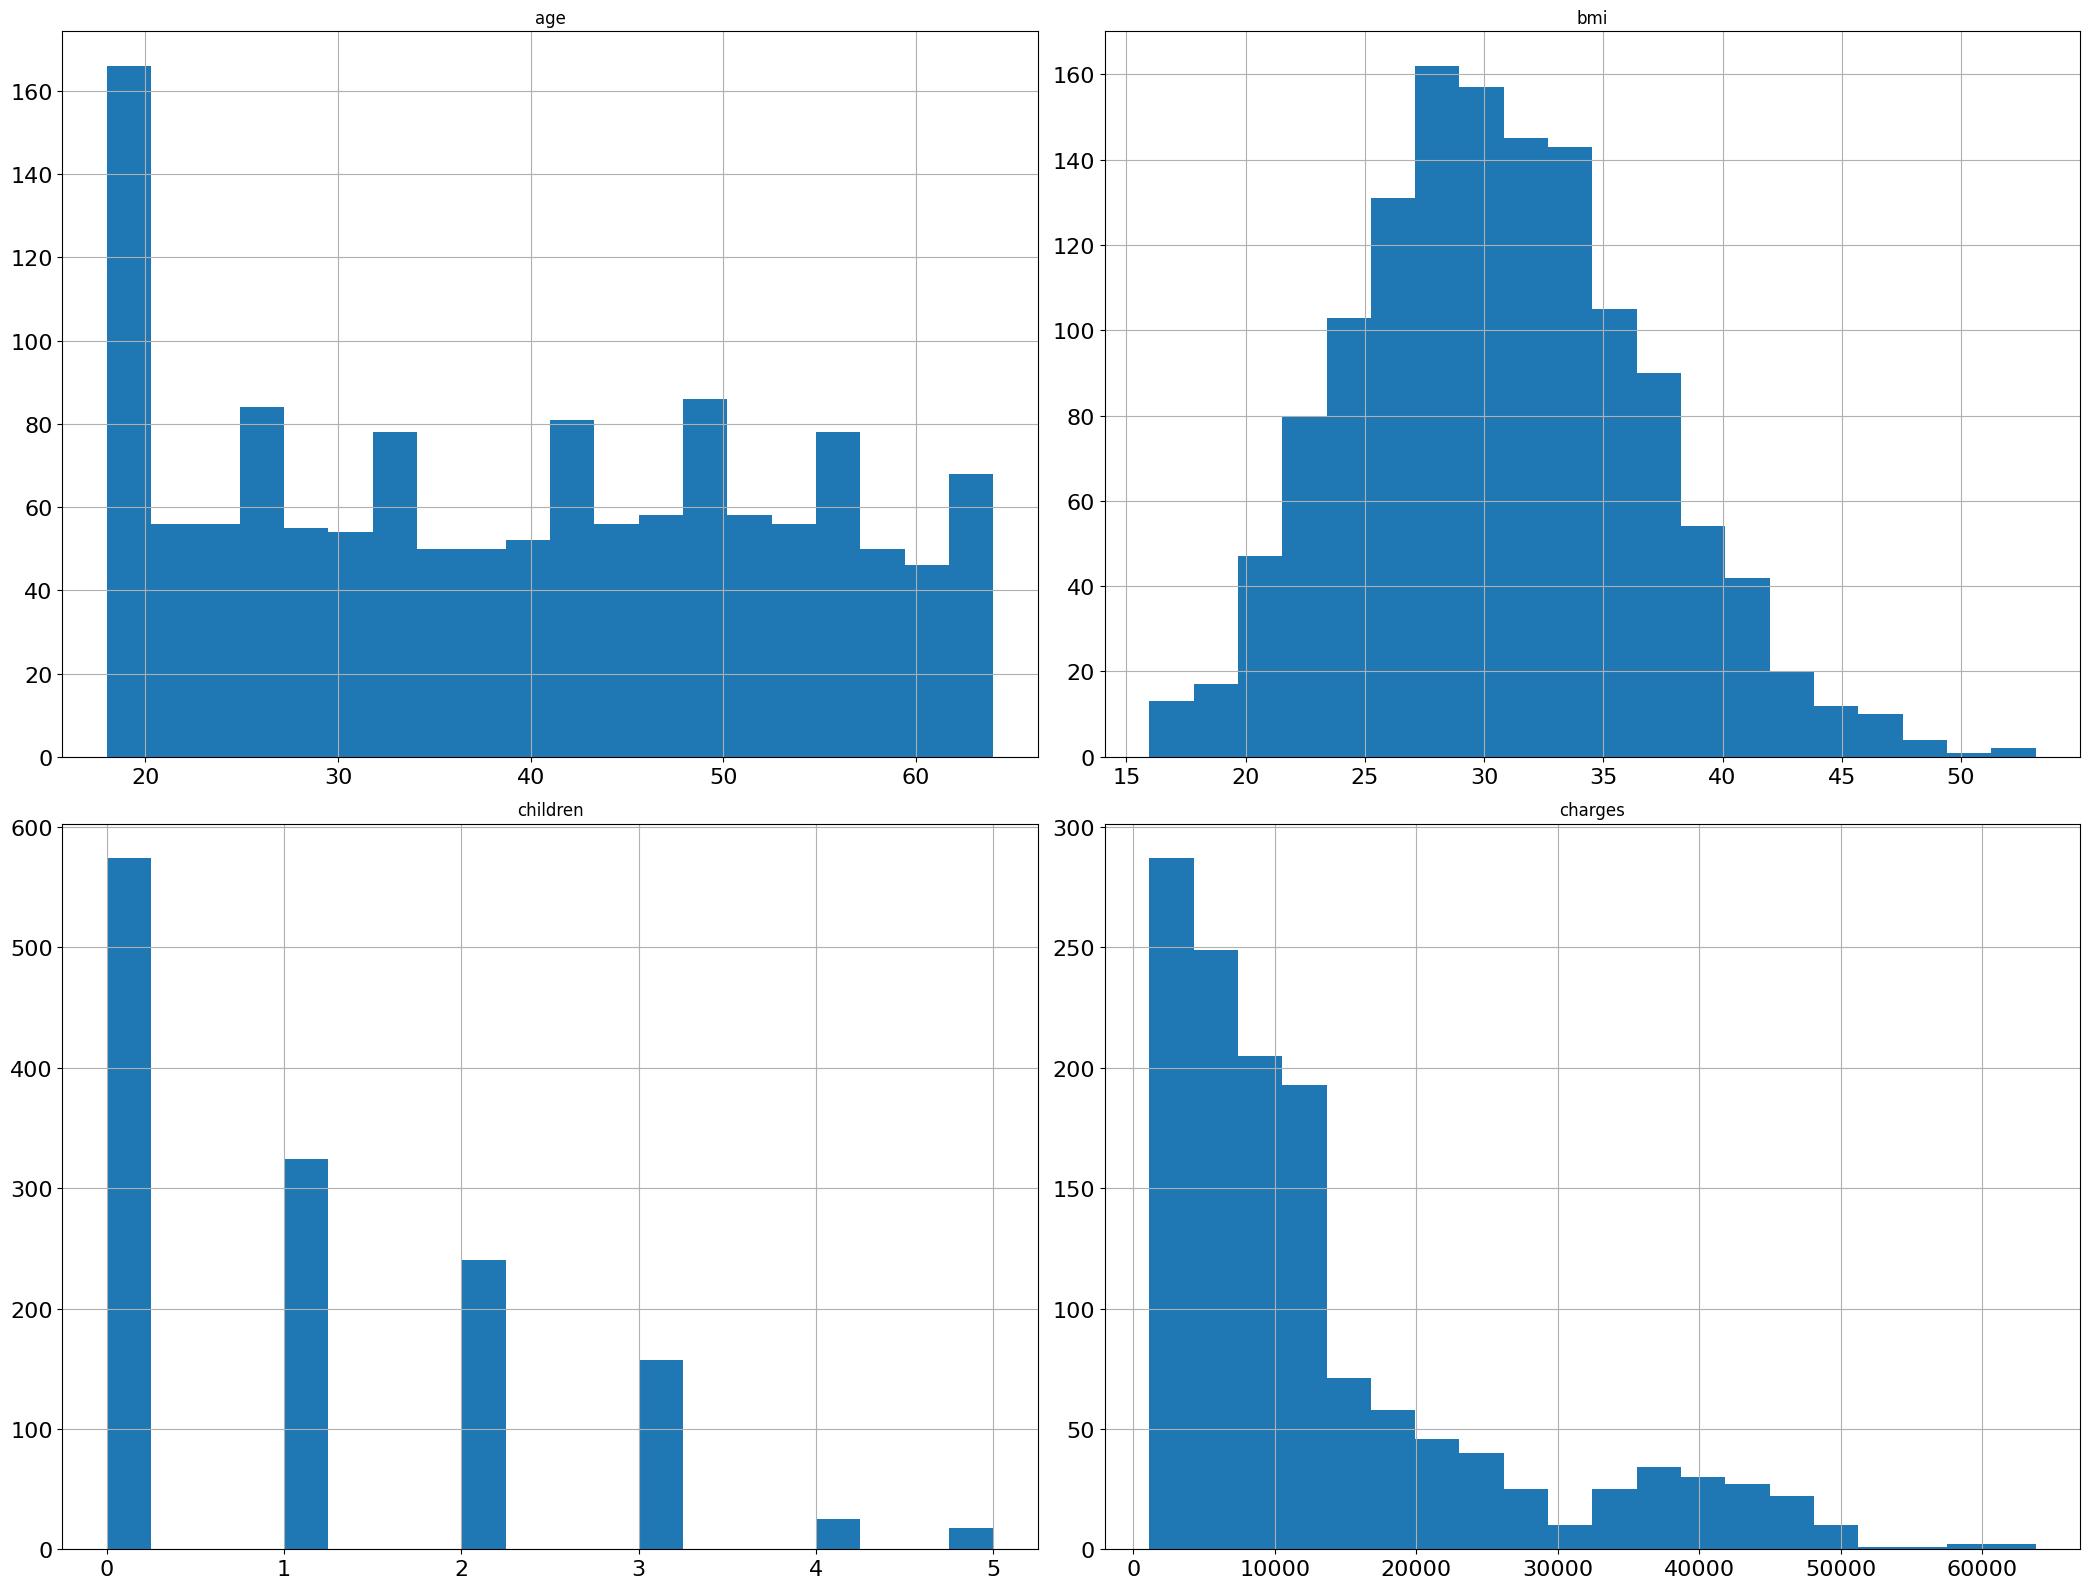

In [ ]:
print(f'Numeric Features Distribution')
# Numerical Distribution
df[num_cols].hist(figsize=(21,16), bins=20, xlabelsize=16, ylabelsize=16, grid=True)
plt.tight_layout()
plt.show()


Categorical Features Dsitribution


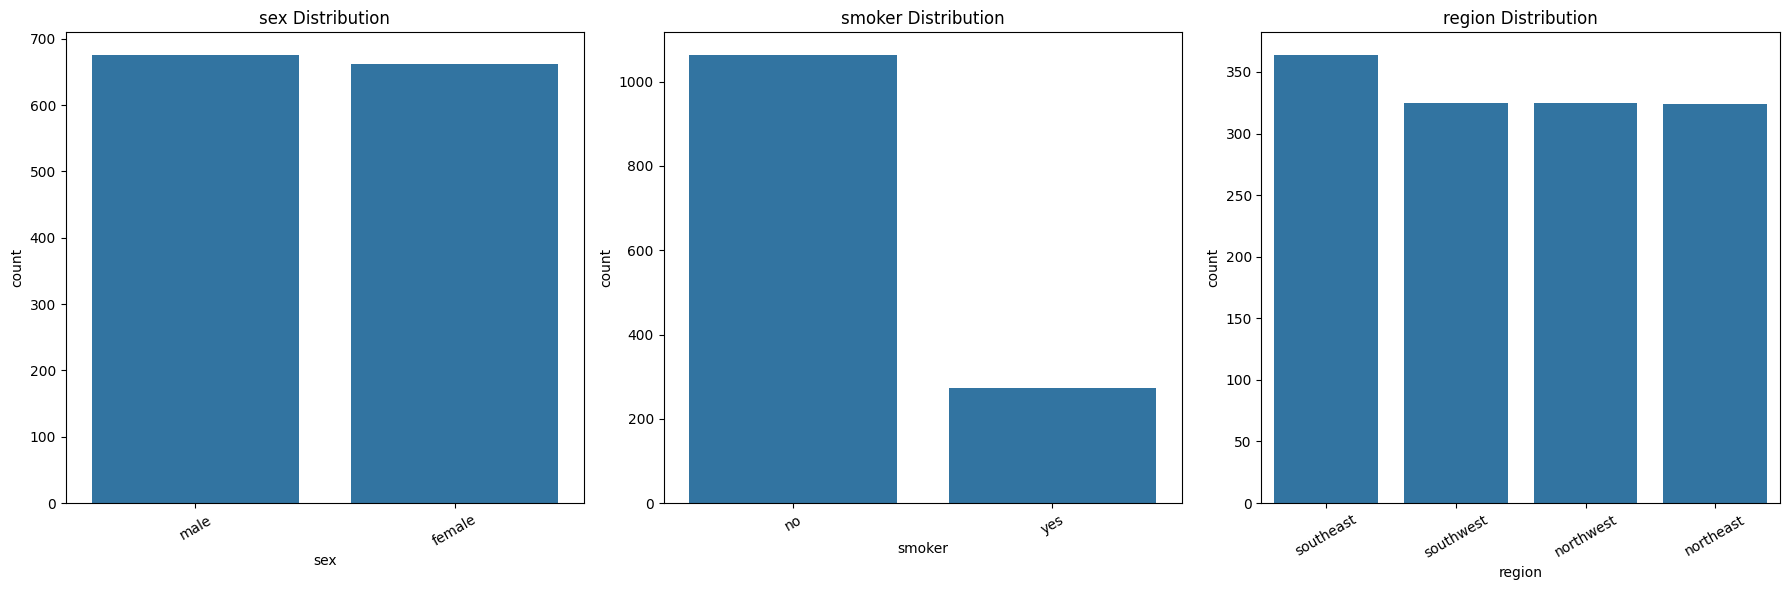

In [45]:
print('Categorical Features Dsitribution')

# Categorical distribution

# Rows and columns (3 per row) in visaulization
ncols = len(cat_cols)
fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(6*ncols, 6))

for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f"{col} Distribution")
    axes[i].tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()



### Bivariate plots

#### BMI vs Charges - by Smoker status

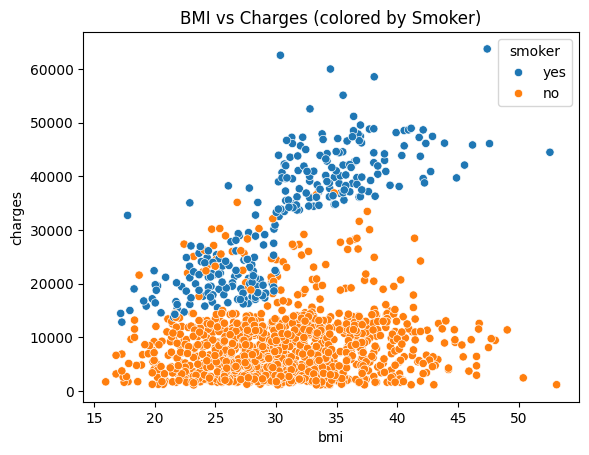

In [ ]:
sns.scatterplot(data=df, x='bmi', y='charges', hue='smoker')
plt.title("BMI vs Charges (colored by Smoker)")
plt.show()

**Analysis:**

Smokers clearly have higher charges at all BMI levels.  
BMI also shows a positive trend with charges, especially for higher values.

#### Age vs Charges

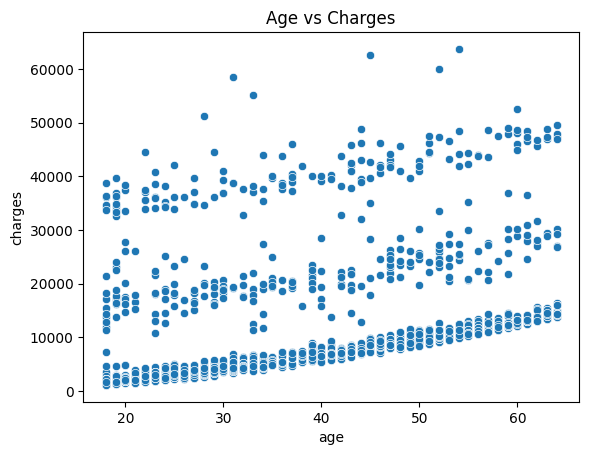

In [56]:
sns.scatterplot(data=df, x='age', y='charges')
plt.title("Age vs Charges")
plt.show()


**Analysis:**

Older clients tend to have higher charges overall.  
The relationship is gradual but noticeable across age groups.

#### Correlation Heatmap

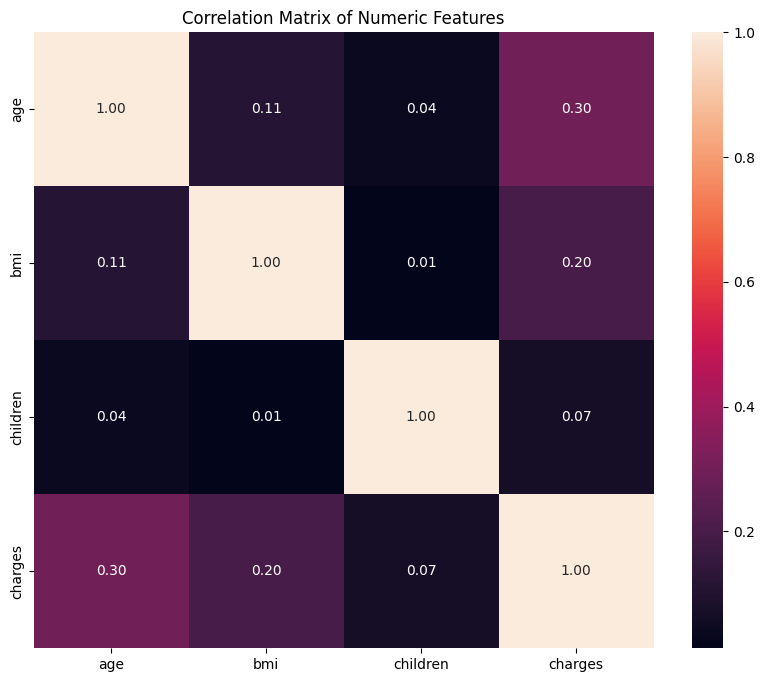

In [58]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=True,fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

**Analysis:**

Charges correlate strongly with BMI and age.  
Other numeric features show weaker correlations.

## 4. Outlier Analysis

In [61]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
# Outlier detection using IQR

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    
    print(f"{col}: {len(outliers)} outliers")


age: 0 outliers
bmi: 9 outliers
children: 0 outliers
charges: 139 outliers


**Outlier Analysis**

- `charges` shows many high-value outliers, consistent with the skewed distribution we noticed before.
- `bmi` has some extreme values above 50.

- Outliers are expected in real insurance data, so I will keep them for now to preserve realism, but note their influence on regression.


## 5. Preprocessing
Encoding

In [ ]:
df_processed = df.copy()

df_processed['sex'] = df_processed['sex'].map({'female': 0, 'male': 1})
df_processed['smoker'] = df_processed['smoker'].map({'no': 0, 'yes': 1})
df_processed = pd.get_dummies(df_processed, columns=['region'], prefix='region')

print("Processed Dataset:", df_processed.shape)

df_processed.head()


Processed Dataset: (1338, 10)


,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,False,True
1,18,1,33.770,1,0,1725.55230,False,False,True,False
2,28,1,33.000,3,0,4449.46200,False,False,True,False
3,33,1,22.705,0,0,21984.47061,False,True,False,False
4,32,1,28.880,0,0,3866.85520,False,True,False,False


## 6. Train/Test

### Split

In [ ]:
X = df_processed.drop(columns='charges')
y = df_processed['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

X_train.head()

Train: (1070, 9), Test: (268, 9)


,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
560,46,0,19.95,2,0,False,True,False,False
1285,47,0,24.32,0,0,True,False,False,False
1142,52,0,24.86,0,0,False,False,True,False
969,39,0,34.32,5,0,False,False,True,False
486,54,0,21.47,3,0,False,True,False,False


### Drop explanation

Removed the following column before training the model:

- `charges`: This is the target variable we want to predict, so it must be separated from the features and not included in the input data.

All other columns (`age`, `sex`, `bmi`, `children`, `smoker`, `region`) were kept as predictors, since they represent demographic and physiological factors that can influence insurance costs.

After this step we are left with meaningful features to train the regression model.


In [68]:
X_train.shape

(1070, 9)

In [69]:
X_test.shape

(268, 9)

In [70]:
X_test

,age,sex,bmi,children,smoker,region_northeast,region_northwest,region_southeast,region_southwest
764,45,0,25.175,2,0,True,False,False,False
887,36,0,30.020,0,0,False,True,False,False
890,64,0,26.885,0,1,False,True,False,False
1293,46,1,25.745,3,0,False,True,False,False
259,19,1,31.920,0,1,False,True,False,False
...,...,...,...,...,...,...,...,...,...
109,63,1,35.090,0,1,False,False,True,False
575,58,0,27.170,0,0,False,True,False,False
535,38,1,28.025,1,0,True,False,False,False
543,54,0,47.410,0,1,False,False,True,False


In [71]:
y_test

764      9095.06825
887      5272.17580
890     29330.98315
1293     9301.89355
259     33750.29180
           ...     
109     47055.53210
575     12222.89830
535      6067.12675
543     63770.42801
846      9872.70100
Name: charges, Length: 268, dtype: float64

## 7. Modeling

In [72]:
#Instance
model = LinearRegression()


In [73]:
#Training
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [74]:
#Predict the Test Dataset
y_pred = model.predict(X_test)
y_pred


array([ 8969.55027444,  7068.74744287, 36858.41091155,  9454.67850053,
       26973.17345656, 10864.11316424,   170.28084137, 16903.45028662,
        1092.43093614, 11218.34318352, 28101.68455267,  9377.73460205,
        5263.0595179 , 38416.04221107, 40255.82339284, 37098.25353123,
       15240.39392306, 35912.88264434,  9112.52398703, 31461.92108909,
        3847.68845883, 10130.12001517,  2370.54189389,  7140.21550828,
       11301.76782638, 12961.65366224, 14509.47251876,  6159.8976107 ,
        9963.85857263,  2177.85718217,  9115.93673493, 13073.68932159,
        4561.82376202,  3408.20756033,  4459.81359745, 13032.06505076,
        1979.99357292,  8813.28303302, 33271.29124448, 32585.51583927,
        3908.76090964,  4326.10774721, 14142.81326533, 11423.45494846,
        8774.13955311, 12097.28051001,  5281.57353499,  3150.5596042 ,
       35494.46461214,  9150.1124786 , 15836.84575621,  2343.57470069,
       12364.78414194,  1482.29488266, 13389.06105161, 12573.57395972,
      

In [76]:
print("R²:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R²: 0.7835929767120724
RMSE: 5796.284659276272


### Residual Analysis

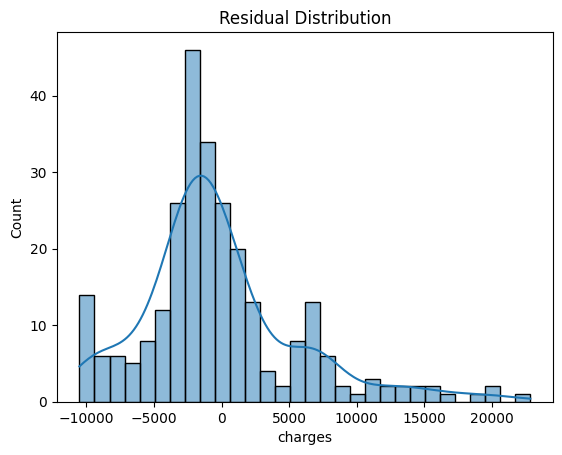

In [77]:
residuals = y_test - y_pred
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residual Distribution")
plt.show()


**Residual Dist Analysis**

Residuals cluster around zero but show a right‑skew of target charges.  
This indicates the model captures general trends well, though extreme high‑cost cases remain harder to predict.


### Optimization

In [78]:
ridge = Ridge(alpha=1.0).fit(X_train, y_train)
lasso = Lasso(alpha=0.01).fit(X_train, y_train)

print("Ridge R²:", r2_score(y_test, ridge.predict(X_test)))
print("Lasso R²:", r2_score(y_test, lasso.predict(X_test)))


Ridge R²: 0.7832964719788794
Lasso R²: 0.783592805571708


### Final Conclusions

The linear regression model explained a good portion of the variation in charges, with an R² close to 0.78 (we capture most but not all important ones) and an RMSE around 5800 (wew are a bit off). That means the model is capturing the main cost drivers, but it still struggles with the extreme high‑charge cases.

When I checked the residuals, they weren’t perfectly balanced, as mentioned there’s a skew that matches the skewed target distribution. This tells me the model is doing its job overall, but the outliers remain tricky, like missing big chunks.

I also tried Ridge and Lasso regularization. The results were almost identical to the baseline, which reassures me that the model is already stable and not overfitting. In practice, smoker status, BMI, and age consistently came out as the strongest predictors of charges, which makes sense given how these factors drive health risks and costs.

Conclusion: linear regression gives a solid baseline, regularization doesn’t change much, and the main challenge is handling the skewed distribution of charges. Maybe exploring non‑linear models to better capture extreme cases.